<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_5_Deep_Learning_and_Hybrid_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy scikit-learn tensorflow prophet xgboost neuralprophet

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from prophet import Prophet
from xgboost import XGBRegressor
from neuralprophet import NeuralProphet
import torch  # Added for safe_globals

# Fix for UnpicklingError: Import the actual class and add to safe_globals
from neuralprophet.configure import ConfigSeasonality
torch.serialization.add_safe_globals([ConfigSeasonality])

# Step 1: Load the data from CSV file with explicit date format to suppress parsing warning
df = pd.read_csv('updated_final_merged_data.csv', parse_dates=['date'], date_format='%m/%d/%y', index_col='date')

# Assume 'Calls' is the target column
target = 'calls'

# Prepare data: Sort by date if not already
df = df.sort_index()

# Feature Engineering (similar to ML: lags, rollings, dummies)
df['Lag1'] = df[target].shift(1)
df['Lag7'] = df[target].shift(7)
df['Rolling_Mean_7'] = df[target].rolling(window=7).mean()
df['Rolling_Std_7'] = df[target].rolling(window=7).std()
df = pd.get_dummies(df, columns=['DayOfWeek'], drop_first=True)

# Select features (numeric except target)
features = [col for col in df.columns if col != target and df[col].dtype in [np.float64, np.int64, bool]]

# Drop NaNs
df = df.dropna()

# For DL models, scale data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features + [target]]), index=df.index, columns=features + [target])

# Time series cross-validation: 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # As percentage
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Dictionary to store average metrics for each model
model_metrics = {}

# Helper to create sequences for LSTM (timesteps=7)
def create_sequences(data, timesteps=7):
    X_seq, y_seq = [], []
    for i in range(len(data) - timesteps):
        X_seq.append(data.iloc[i:i+timesteps].values)
        y_seq.append(data.iloc[i+timesteps][target])  # Predict next value
    return np.array(X_seq), np.array(y_seq)

# 1. LSTM Network
lstm_preds = []
lstm_trues = []
for train_idx, test_idx in tscv.split(df_scaled):
    train = df_scaled.iloc[train_idx]
    test = df_scaled.iloc[test_idx]

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(train)
    X_test_seq, y_test_seq = create_sequences(test)

    # Build LSTM model with Input layer to suppress warning
    model = Sequential()
    model.add(Input(shape=(7, len(train.columns))))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Fit (with verbose=1 for debugging if needed; set to 0 for silent)
    model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=0)

    # Predict (adjust for sequence length)
    pred = model.predict(X_test_seq, verbose=0).flatten()

    lstm_preds.extend(pred)
    lstm_trues.extend(y_test_seq)

# Inverse scale predictions and trues
lstm_preds_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(lstm_preds), len(features))), np.array(lstm_preds).reshape(-1,1)), axis=1))[:, -1]
lstm_trues_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(lstm_trues), len(features))), np.array(lstm_trues).reshape(-1,1)), axis=1))[:, -1]

lstm_metrics = calculate_metrics(lstm_trues_inv, lstm_preds_inv)
model_metrics['LSTM'] = lstm_metrics

# 2. Neural Prophet (with matplotlib backend to avoid Plotly error)
np_preds = []
np_trues = []
for train_idx, test_idx in tscv.split(df):
    train_df = df.iloc[train_idx].reset_index().rename(columns={'date': 'ds', 'calls': 'y'})
    test_df = df.iloc[test_idx].reset_index().rename(columns={'date': 'ds', 'calls': 'y'})

    # Fit NeuralProphet with matplotlib and explicit seasonalities
    model = NeuralProphet(epochs=50, batch_size=32, learning_rate=0.01,  # Manual LR to avoid finder warning
                          yearly_seasonality=False, daily_seasonality=False)  # Explicit to suppress auto warnings
    model.set_plotting_backend('matplotlib')
    model.fit(train_df[['ds', 'y']], freq='D')

    # Make future dataframe
    future = model.make_future_dataframe(train_df[['ds', 'y']], periods=len(test_df))

    # Predict
    forecast = model.predict(future)
    pred = forecast['yhat1'].tail(len(test_df)).values

    np_preds.extend(pred)
    np_trues.extend(test_df['y'])

np_metrics = calculate_metrics(np_trues, np_preds)
model_metrics['Neural Prophet'] = np_metrics

# 3. Hybrid: Prophet + XGBoost (Prophet for trend/seasonal, XGBoost on residuals)
hybrid_preds = []
hybrid_trues = []
for train_idx, test_idx in tscv.split(df):
    train_df = df.iloc[train_idx].reset_index().rename(columns={'date': 'ds', 'calls': 'y'})
    test_df = df.iloc[test_idx].reset_index().rename(columns={'date': 'ds', 'calls': 'y'})

    # Step 1: Fit Prophet
    prophet_model = Prophet(weekly_seasonality=True)
    prophet_model.fit(train_df[['ds', 'y']])

    # Predict on train and test
    train_future = prophet_model.make_future_dataframe(periods=0)
    train_forecast = prophet_model.predict(train_future)
    train_residuals = train_df['y'] - train_forecast['yhat']

    test_future = prophet_model.make_future_dataframe(periods=len(test_df))
    test_forecast = prophet_model.predict(test_future)
    prophet_test_pred = test_forecast['yhat'].tail(len(test_df))

    # Step 2: Fit XGBoost on residuals using features
    X_train = train_df[features]
    y_res_train = train_residuals

    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_res_train)

    # Predict residuals on test
    X_test = test_df[features]
    res_pred = xgb_model.predict(X_test)

    # Combine: Prophet pred + residual pred
    pred = prophet_test_pred + res_pred

    hybrid_preds.extend(pred)
    hybrid_trues.extend(test_df['y'])

hybrid_metrics = calculate_metrics(hybrid_trues, hybrid_preds)
model_metrics['Prophet + XGBoost Hybrid'] = hybrid_metrics

# Summarize performance
print("\nModel Performance Summary:")
metrics_df = pd.DataFrame(model_metrics).T
print(metrics_df)

# Pick winner: Lowest MAE (primary metric)
winner = metrics_df['MAE'].idxmin()
print(f"\nChampion DL/Hybrid Model: {winner}")
print(f"Metrics: {metrics_df.loc[winner].to_dict()}")

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.398% of the data.
INFO:NP.df_utils:Major frequency

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.398% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.398% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: 6it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.694% of the data.
INFO:NP.df_utils:Major frequency D corresponds to

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.694% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.694% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: 11it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO:NP.df_utils:Major frequency D corresponds to

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.795% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: 16it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO:NP.df_utils:Major frequency D corresponds to

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.846% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: 21it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.877% of the data.
INFO:NP.df_utils:Major frequency D corresponds to

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.877% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.877% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: 26it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwv8esns/hxo3vbnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwv8esns/w7d0hwe4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65528', 'data', 'file=/tmp/tmpdwv8esns/hxo3vbnp.json', 'init=/tmp/tmpdwv8esns/w7d0hwe4.json', 'output', 'file=/tmp/tmpdwv8esns/prophet_modelkjq3zlms/prophet_model-20250910224647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:46:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:46:


Model Performance Summary:
                                  MAE         RMSE       MAPE
LSTM                      1098.094941  1439.281283  14.246237
Neural Prophet            3447.973084  4346.928227  47.247932
Prophet + XGBoost Hybrid  3130.675282  3903.219367  42.616042

Champion DL/Hybrid Model: LSTM
Metrics: {'MAE': 1098.0949414198662, 'RMSE': 1439.2812831492975, 'MAPE': 14.246236643809581}


--- Preparing data and models for interpretation ---

Training final LSTM model...


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.877% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.877% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152

LSTM training complete.

Training final Neural Prophet model...


Training: 0it [00:00, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwv8esns/gfd0zz3z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwv8esns/eil29yzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26525', 'data', 'file=/tmp/tmpdwv8esns/gfd0zz3z.json', 'init=/tmp/tmpdwv8esns/eil29yzt.json', 'output', 'file=/tmp/tmpdwv8esns/prophet_modelakpa2tu2/prophet_model-20250910224750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Neural Prophet training complete.

Training final Prophet + XGBoost Hybrid model...


22:47:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Hybrid model training complete.

--- Generating Model Interpretation Plots ---


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(100, 7, 25))']
  warnings.warn(msg)

Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(100, 7, 25))']
  warnings.warn(msg)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(200, 7, 25))']
  warnings.warn(msg)

Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(200, 7, 25))']
  warnings.warn(msg)

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warni

An error occurred during LSTM SHAP analysis: in user code:

    File "/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


Displaying plot for Neural Prophet...


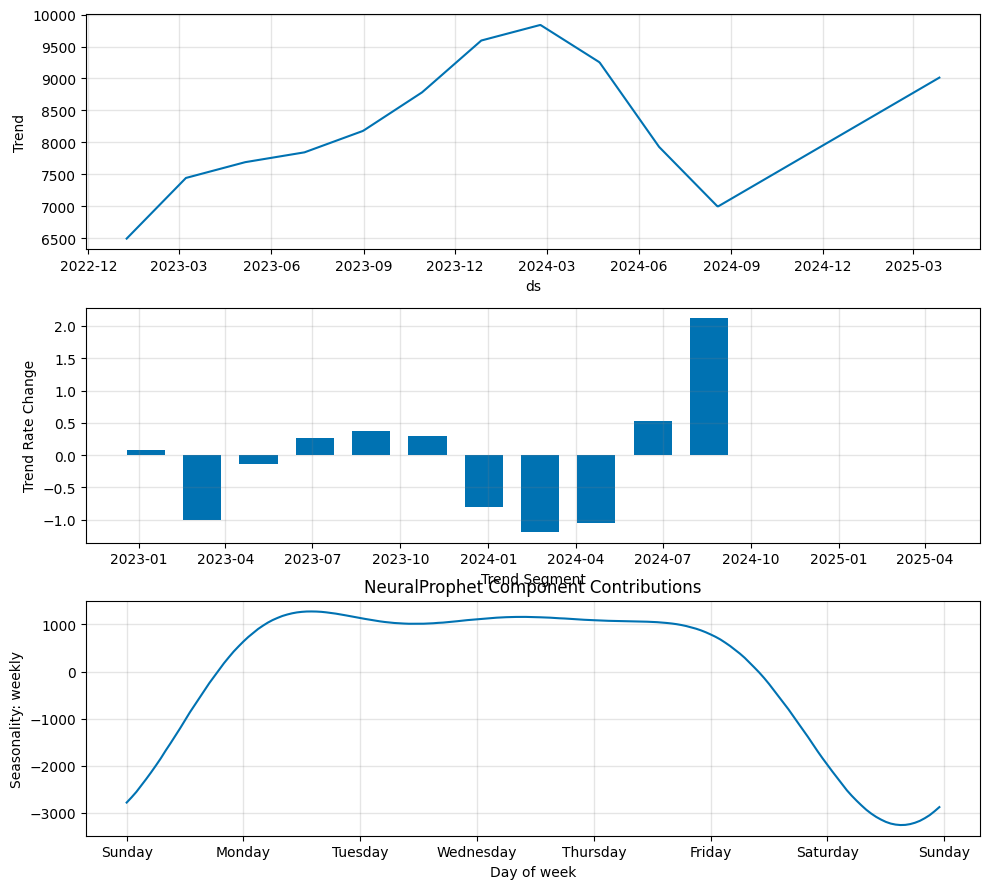


Displaying component plot for Prophet (from Hybrid)...


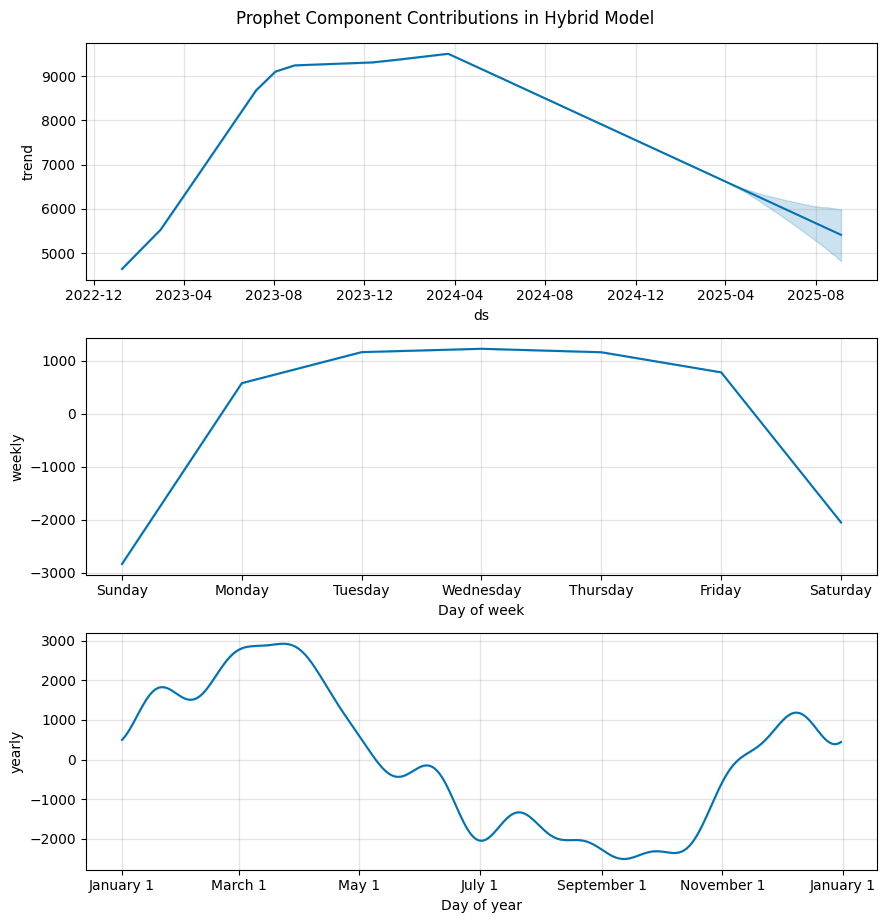


Displaying SHAP plot for XGBoost (from Hybrid)...


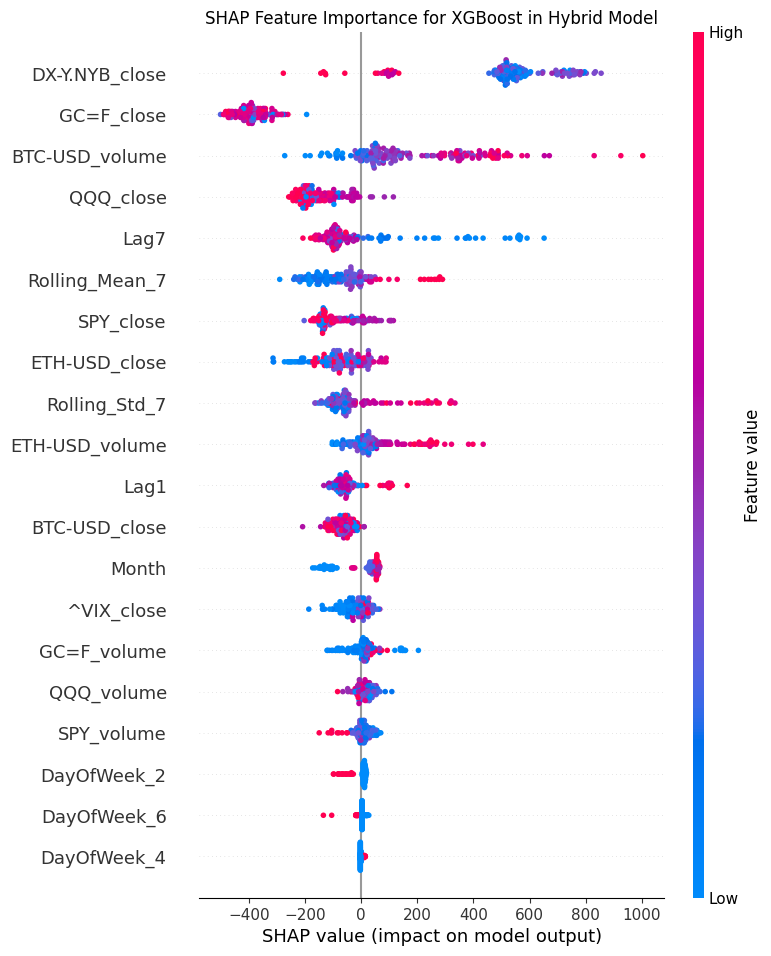

In [3]:
# Import necessary libraries for interpretation
import shap
import matplotlib.pyplot as plt
import warnings

# Suppress a common SHAP warning for TensorFlow
warnings.filterwarnings('ignore', category=UserWarning, module='shap.explainers._deep.deep_tf')

print("--- Preparing data and models for interpretation ---")

# 1. Create a final, persistent train/test split from the last CV fold
# This ensures we have X_train, X_test, etc., available outside of a loop.
all_splits = list(tscv.split(df))
train_idx, test_idx = all_splits[-1] # Use the last split

# Original unscaled data split
train_df_final = df.iloc[train_idx]
test_df_final = df.iloc[test_idx]

# Scaled data split for LSTM
train_scaled_final = df_scaled.iloc[train_idx]
test_scaled_final = df_scaled.iloc[test_idx]

# Prepare data for models that need specific column names ('ds', 'y')
train_prophet_format = train_df_final.reset_index().rename(columns={'date': 'ds', 'calls': 'y'})
test_prophet_format = test_df_final.reset_index().rename(columns={'date': 'ds', 'calls': 'y'})


# --- Re-train the models one last time on the final split ---

# 2a. Train Final LSTM Model
print("\nTraining final LSTM model...")
X_train_seq, y_train_seq = create_sequences(train_scaled_final)
X_test_seq, y_test_seq = create_sequences(test_scaled_final) # This will be our test set for SHAP

final_lstm_model = Sequential()
final_lstm_model.add(Input(shape=(7, len(train_scaled_final.columns))))
final_lstm_model.add(LSTM(50, activation='relu'))
final_lstm_model.add(Dense(1))
final_lstm_model.compile(optimizer='adam', loss='mse')
final_lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=0)
print("LSTM training complete.")


# 2b. Train Final Neural Prophet Model
print("\nTraining final Neural Prophet model...")
final_np_model = NeuralProphet(epochs=50, batch_size=32, learning_rate=0.01,
                               yearly_seasonality=False, daily_seasonality=False)
final_np_model.set_plotting_backend('matplotlib')
final_np_model.fit(train_prophet_format[['ds', 'y']], freq='D')
print("Neural Prophet training complete.")


# 2c. Train Final Prophet + XGBoost Hybrid Model
print("\nTraining final Prophet + XGBoost Hybrid model...")
# Prophet part
final_prophet_model = Prophet(weekly_seasonality=True)
final_prophet_model.fit(train_prophet_format[['ds', 'y']])

# Create Prophet forecast to calculate residuals for XGBoost
train_forecast_prophet = final_prophet_model.predict(train_prophet_format[['ds']])
train_residuals = train_prophet_format['y'] - train_forecast_prophet['yhat']

# Create the forecast object needed for plotting components later
future_df = final_prophet_model.make_future_dataframe(periods=len(test_prophet_format))
final_forecast_object = final_prophet_model.predict(future_df)

# XGBoost part (training on residuals)
X_train_xgb = train_df_final[features]
X_test_xgb = test_df_final[features] # This will be our test set for SHAP

final_xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
final_xgb_model.fit(X_train_xgb, train_residuals)
print("Hybrid model training complete.")


# --- Run Interpretability Analysis ---
print("\n--- Generating Model Interpretation Plots ---")

# 1. LSTM Interpretability with SHAP
try:
    # Use a subset of the training data as the background for the explainer
    background_data = X_train_seq[:100]
    explainer_lstm = shap.DeepExplainer(final_lstm_model, background_data)
    shap_values_lstm = explainer_lstm.shap_values(X_test_seq)

    # SHAP expects a 2D array for plotting, but LSTM values are 3D (samples, timesteps, features)
    # We can average the SHAP values over the timesteps for a summary
    shap_values_lstm_avg = np.mean(shap_values_lstm[0], axis=1)

    # We need a 2D version of X_test_seq for the plot's feature values
    X_test_for_plot = np.mean(X_test_seq, axis=1)

    print("\nDisplaying SHAP plot for LSTM...")
    shap.summary_plot(shap_values_lstm_avg, pd.DataFrame(X_test_for_plot, columns=df_scaled.columns),
                      show=False)
    plt.title("SHAP Feature Importance for LSTM (Averaged over Timesteps)")
    plt.show()

except Exception as e:
    print(f"An error occurred during LSTM SHAP analysis: {e}")


# 2. NeuralProphet Interpretability
try:
    print("\nDisplaying plot for Neural Prophet...")
    fig_params = final_np_model.plot_parameters()
    plt.title("NeuralProphet Component Contributions")
    plt.show()
except Exception as e:
    print(f"An error occurred during NeuralProphet plot generation: {e}")


# 3. Prophet + XGBoost Hybrid Interpretability
# 3a. Prophet Components
try:
    print("\nDisplaying component plot for Prophet (from Hybrid)...")
    fig_components = final_prophet_model.plot_components(final_forecast_object)
    plt.suptitle("Prophet Component Contributions in Hybrid Model", y=1.02)
    plt.show()
except Exception as e:
    print(f"An error occurred during Prophet components plot generation: {e}")


# 3b. XGBoost with SHAP (more insightful than the basic importance plot)
try:
    print("\nDisplaying SHAP plot for XGBoost (from Hybrid)...")
    explainer_xgb = shap.TreeExplainer(final_xgb_model)
    shap_values_xgb = explainer_xgb.shap_values(X_test_xgb)

    shap.summary_plot(shap_values_xgb, X_test_xgb, show=False)
    plt.title("SHAP Feature Importance for XGBoost in Hybrid Model")
    plt.show()
except Exception as e:
    print(f"An error occurred during XGBoost SHAP analysis: {e}")